In [ ]:
from IPython.display import clear_output, display

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import flopy

In [ ]:
from new_york_build_mf import dflowfm_to_array

In [ ]:
from dfm_tools.get_nc import get_ncmodeldata, plot_netmapdata, get_netdata
from dfm_tools.get_nc_helpers import get_timesfromnc

In [ ]:
stage_cmap = colors.ListedColormap(["cyan"])

In [ ]:
nc_path = "model_dfmf/DFM_OUTPUT_model_dfmf/model_dfmf_map.nc"

In [ ]:
dflowfm_times = get_timesfromnc(file_nc=nc_path, varname="time")
dflowfm_times

In [ ]:
ugrid_all = get_netdata(file_nc=nc_path)
data_frommap_wl = get_ncmodeldata(
    file_nc=nc_path, varname="mesh2d_s1", timestep="all"
)

In [ ]:
x = get_ncmodeldata(file_nc=nc_path, varname="mesh2d_face_x")
y = get_ncmodeldata(file_nc=nc_path, varname="mesh2d_face_y")
xy = [(xx, yy) for (xx, yy) in zip(x, y)]

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_ws="model_dfmf")
gwf = sim.get_model()
top = gwf.dis.top.array

In [ ]:
times = np.array(gwf.output.head().get_times())
ntimes = times.shape[0]
ntimes, times

In [ ]:
v = gwf.output.head().get_alldata()
v.min(), v.max()

In [ ]:
cbc = gwf.output.budget()

In [ ]:
cbc.get_unique_record_names()

#### create structured grid for dflowfm

In [ ]:
nrow, ncol = gwf.modelgrid.nrow, gwf.modelgrid.ncol
dflowfm_modelgrid = flopy.discretization.StructuredGrid(
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr=gwf.modelgrid.delr,
    delc=gwf.modelgrid.delc,
    xoff=gwf.modelgrid.xoffset,
    yoff=gwf.modelgrid.yoffset,
    botm=top.copy().reshape(1, nrow, ncol),
    top=np.full((nrow, ncol), 5.0, dtype=float),
)

### MODFLOW Boundary Conditions

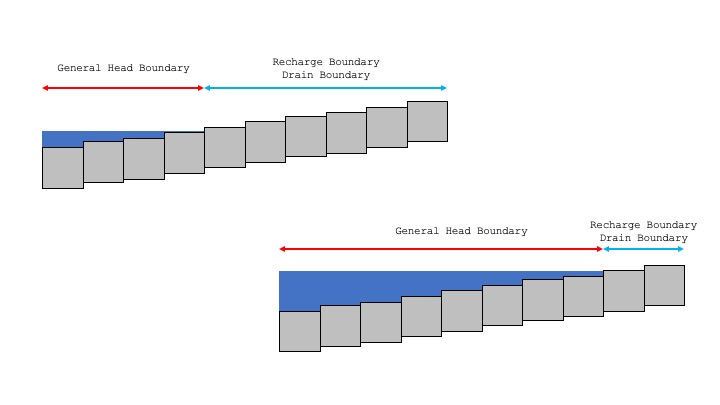

#### animate results

In [ ]:
extent = (0, 11, -20, 5)
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(4)
fig.set_figwidth(5)

for idx in range(ntimes):

    ax.cla()

    head = gwf.output.head().get_data(totim=times[idx])
    spdis = cbc.get_data(text="DATA-SPDIS", totim=times[idx])[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    dflowfm_stage = dflowfm_to_array(
        gwf.modelgrid, xy, data_frommap_wl[idx + 1, :], two_dimensional=True
    )
    dflowfm_stage[:, 0] = dflowfm_stage[:, 1]

    xs = flopy.plot.PlotCrossSection(
        model=gwf, line={"row": 5}, ax=ax, extent=extent
    )
    xs.ax.axhline(y=0.0, lw=0.5, ls=":", color="black")
    pv = xs.plot_array(head, head=head, vmin=2, vmax=4)
    vector = xs.plot_vector(qx, qy, qz, head=head, normalize=True)
    xs.plot_grid()
    if idx == 0:
        plt.colorbar(pv, ax=ax)

    xs_df = flopy.plot.PlotCrossSection(
        modelgrid=dflowfm_modelgrid, ax=ax, line={"row": 5}, extent=extent
    )
    ps = xs_df.plot_array(dflowfm_stage, head=dflowfm_stage, cmap=stage_cmap)
    title_text = fig.suptitle(f"{dflowfm_times[idx+1]}")

    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)